# Figure 7

This Jupyter Notebook contains the code for generating the plots used in Figure 7 of the manuscript. To build these plots, we first ran a SLiM simulation in two dimensions with a individuals grouped into one of two subpopulations in the area. These subpopulations were geographically separated from each other at the start of the simulation. After running the simulation for a set amount of time, SLiM returns the complete tree sequence. We filter this tree sequence and then identify an admixed individual with an interesting recombination event. Finally, we estimate the chromosome regions on either side of that recombination event using multiple methods. 

In [6]:
import sparg
import tskit
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("always")

## Building the SpatialARG

We filter to 100 samples and simplify the ARG to only nodes that affect the topology. We calculate the SpatialARG and then reset the dispersal rate matrix of the SpatialARG to the effective dispersal rate from the simulation because we have shown that dispersal rate estimates from the sparg method are biased.

In [2]:
ts = tskit.load("../../simulations/TwoPopsTwoDims/outputs/original/S025_I1_R2_W100_D2/rep1_S025_I1_R2_W100_D2.trees")

np.random.seed(4)
samples = list(np.random.choice(ts.samples(), 100, replace=False))
ts_sim, map_sim = ts.simplify(samples=samples, map_nodes=True, keep_input_roots=False, keep_unary=True, update_sample_flags=False)
ts_small, maps_small = sparg.simplify_with_recombination(ts=ts_sim, flag_recomb=True)
spatial_arg = sparg.SpatialARG(ts=ts_small, verbose=True)

# reset the dispersal rate matrix to the theoretical value
spatial_arg.dispersal_rate_matrix = np.array([[0.25*0.25+0.5,0],[0,0.25*0.25+0.5]])

/opt/anaconda3/envs/sparg/lib/python3.12/site-packages/sparg/__init__.py:142: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  recomb_nodes = ts.edges_parent[np.in1d(ts.edges_child, multiple_parents)] #Find the parent nodes of the children with multiple parents.


Prepared input parameters - Section Elapsed Time: 0.0 - Total Elapsed Time: 0.0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1940/1940 [00:01<00:00, 1045.13it/s]


Calculated covariance matrix - Section Elapsed Time: 1.92 - Total Elapsed Time: 1.92
Inverted covariance matrix - Section Elapsed Time: 0.18 - Total Elapsed Time: 2.11
Created root locations vector - Section Elapsed Time: 0.67 - Total Elapsed Time: 2.77
Estimated dispersal rate - Section Elapsed Time: 0.0 - Total Elapsed Time: 2.77
Calculated Fisher's information matrices - Section Elapsed Time: 0.0 - Total Elapsed Time: 2.77
Completed building SpatialARG object - Total Elapsed Time: 2.77


## Locating interesting recombination events

For this figure, we want a relatively centrally placed recombination about half way into the past (500 generations) that separates neighboring blocks are tracked to different ancestral subpopulations. These conditions create the classic "Y" shape where the blocks are together in the recent past before splitting to  

In [3]:
location_x = []
composition = []

subpop_and_seq_len = [[0 for subpop in range(2)] for s in ts_small.samples()]

for tree in ts_small.trees():
    for root in tree.roots:
        if ts_small.individual(ts_small.node(root).individual).location[0] < 50:
            subpop = 0
        else:
            subpop = 1
        for leaf in tree.samples(root):
            subpop_and_seq_len[leaf][subpop] += tree.span

for j,sample in enumerate(subpop_and_seq_len):
    location_x.append(ts_small.individual(ts_small.node(j).individual).location[0])
    comp_per = subpop_and_seq_len[j][1] / sum(subpop_and_seq_len[j])
    composition.append(comp_per)
    loc = ts_small.individual(ts_small.node(j).individual).location[0]
    if comp_per >= 0.4 and comp_per <= 0.6 and loc >= 40 and loc <= 60:
        sample_blocks = [[] for i in range(ts_small.num_samples)]
        ts_sample = ts_small.simplify(samples=[j], keep_input_roots=False, keep_unary=True, update_sample_flags=False)
        breakpoints = list(ts_sample.breakpoints())
        sample_blocks = []
        for tree in ts_sample.trees():
            for root in tree.roots:
                if ts_sample.individual(ts_sample.node(root).individual).location[0] < 50:
                    subpop = 0
                else:
                    subpop = 1
                for leaf in tree.samples(root):
                    sample_blocks.append(subpop)
        for i,block in enumerate(sample_blocks[:-1]):
            if block != sample_blocks[i+1]:
                tree_left = list(ts_sample.at((breakpoints[i]+breakpoints[i+1])/2).nodes())
                tree_right = list(ts_sample.at((breakpoints[i+1]+breakpoints[i+2])/2).nodes())
                for node in reversed(tree_left):
                    if node not in tree_right:
                        if ts_sample.node(node).time >= 250 and ts_sample.node(node).time <= 500:
                            print(j, breakpoints[i+1], (breakpoints[i]+breakpoints[i+1])/2, (breakpoints[i+1]+breakpoints[i+2])/2, ts_sample.node(node).time)
                        break
                

63 788699.0 710431.0 804871.5 412.0
66 314087.0 271444.5 362364.5 432.0
66 794848.0 782765.0 868002.5 405.0
96 314087.0 271444.5 393793.0 432.0
96 794848.0 782765.0 806929.0 405.0


# Tracking the sample

We choose the first of the samples-breakpoint combinations that fits our criteria. We estimate the locations of chromosome regions on either side of this breakpoint in two ways: 1) using the full chromosome and 2) using just the local tree for either side.

In [4]:
sample = 63
bp_interest = 788699.0

locations_df = sparg.create_recombination_event_dataframe(
    ts=ts_sim,
    breakpoint=bp_interest,
    samples=[sample],
    include_locations=True
)

locations_df = sparg.estimate_locations_of_ancestors_in_dataframe_using_arg(df=locations_df, spatial_arg=spatial_arg)
locations_df = sparg.estimate_locations_of_ancestors_in_dataframe_using_window(df=locations_df, spatial_arg=spatial_arg, window_size=-1, use_theoretical_dispersal=True)

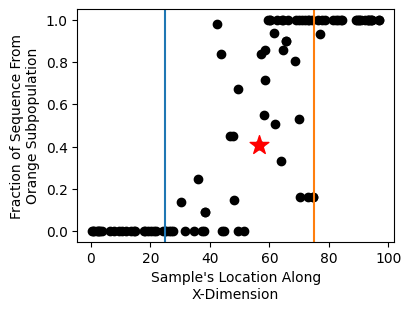

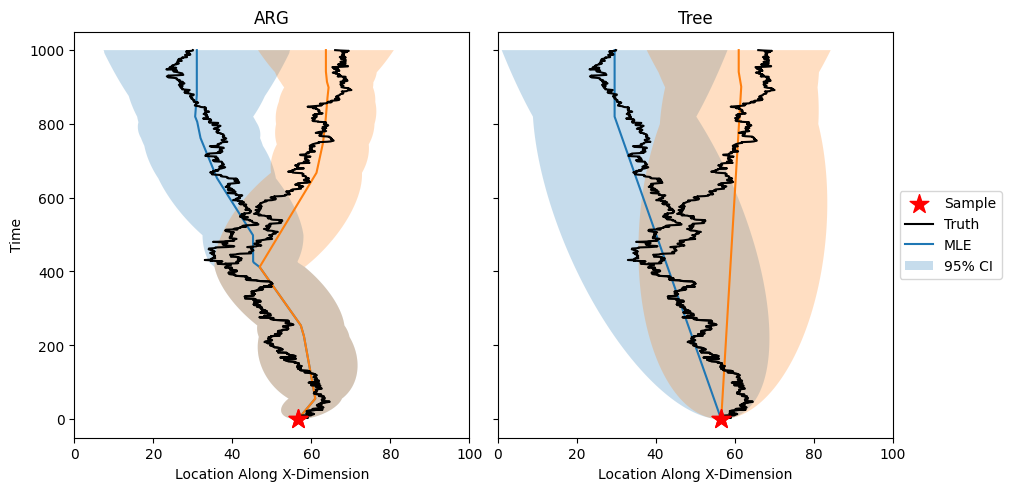

In [5]:
fig, (ax0) = plt.subplots(nrows=1, ncols=1, layout="constrained", sharey=True)

ax0.scatter(location_x, composition, color="black", alpha=1)
ax0.scatter(location_x[sample], composition[sample], color="red", s=200, marker="*")
ax0.axvline(x = 25, label = "Starting Location of Blue Subpopulation")
ax0.axvline(x = 75, color = "#ff7f0e", label = "Starting Location of Orange Subpopulation")
ax0.set_xlabel("Sample's Location Along\nX-Dimension")
ax0.set_ylabel("Fraction of Sequence From\nOrange Subpopulation")

fig.set_figwidth(4)
fig.set_figheight(3)
#plt.savefig("subfigures/Fig7_Comp.svg")
plt.show()

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, layout="constrained", sharey=True)

ax1.scatter(locations_df.loc[locations_df["time"]==0,"true_location_0"],locations_df.loc[locations_df["time"]==0,"time"], color="red", s=200, marker="*", zorder=4)
ax2.scatter(locations_df.loc[locations_df["time"]==0,"true_location_0"],locations_df.loc[locations_df["time"]==0,"time"], color="red", s=200, marker="*", zorder=4, label="Sample")

counter = 0
for i,region in locations_df.groupby(["sample", "genome_position"]):
    if i == (sample, bp_interest-1) or i == (sample, bp_interest+1):
        ax1.plot(region["true_location_0"], region["time"], color="black", zorder=3)
        if counter == 0:
            ax2.plot(region["true_location_0"], region["time"], label="Truth", color="black", zorder=3)
        else:
            ax2.plot(region["true_location_0"], region["time"], color="black", zorder=3)
        counter += 1

counter = 0
for i,region in locations_df.groupby(["sample", "genome_position"]):
    if i == (sample, bp_interest-1) or i == (sample, bp_interest+1):
        left = []
        right = []
        for i,row in region.iterrows():
            left.append(row["arg_estimated_location_0"]-1.96*math.sqrt(round(row["arg_variance_in_estimated_location_0"],3)))
            right.append(row["arg_estimated_location_0"]+1.96*math.sqrt(round(row["arg_variance_in_estimated_location_0"],3)))
        ax1.fill_betweenx(
            y=region["time"],
            x1=left,
            x2=right,
            alpha=0.25
        )
        ax1.plot(region["arg_estimated_location_0"], region["time"])

        left = []
        right = []
        for i,row in region.iterrows():
            left.append(row["window_-1_estimated_location_0"]-1.96*math.sqrt(round(row["window_-1_variance_in_estimated_location_0"],3)))
            right.append(row["window_-1_estimated_location_0"]+1.96*math.sqrt(round(row["window_-1_variance_in_estimated_location_0"],3)))
        if counter == 0:
            ax2.plot(region["window_-1_estimated_location_0"], region["time"], label="MLE")
            ax2.fill_betweenx(
                y=region["time"],
                x1=left,
                x2=right,
                alpha=0.25,
                label="95% CI"
            )
        else:
            ax2.fill_betweenx(
                y=region["time"],
                x1=left,
                x2=right,
                alpha=0.25
            )
            ax2.plot(region["window_-1_estimated_location_0"], region["time"])
        counter += 1

ax1.set_title("ARG")
ax2.set_title("Tree")

ax1.set_xlabel("Location Along X-Dimension")
ax1.set_ylabel("Time")
ax2.set_xlabel("Location Along X-Dimension")

ax1.set_xlim(0,100)
ax2.set_xlim(0,100)

ax2.legend(bbox_to_anchor=(1, 0.625))

fig.set_figwidth(10)
#plt.savefig("subfigures/Fig7_Tracking_V2.svg")
plt.show()